## Introduction

Accurately estimating the value of housing is an important problem for many stakeholders including house owners, house buyers, agents and even investors. Despite it is commonly believed that the size, the total number of rooms and loactions will play a major part affecting the price, there are still many other factors that might come into play. Therefore, I decide to dive into this Kaggle project: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/. 

With 79 explanatory variables depicting aspects of residential homes in Ames, Iowa, we aim to predict the housing price with the most relevant predictors. To begin with, we implement Data Cleaning and EDA to select only a few predictors that are both more relevant to the target variable SalePrices and balanced as predictors. Then we standardize the value of chosen predictors to make sure we can compare the coefficients across different predictors. Next, we remove some outliers before fitting the models.

For Model Implementation, we adopted two types of modeling methods. The Penalizing regression models includes Linear Regression, LASSO Regression, and Ridge Regression. The Tree based models include Decision Tree, Random Forest, and XG-Boost. We compare their modeling performance using MSE as criteria. At the end, we provide some discussion and draw our conclusion in final.

In [34]:
# import all needed packages 
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler  
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

### Import Data

In [3]:
df_train = pd.read_csv('/Users/stellayz/Desktop/Github/House Price/data/train.csv') #1 - 1460
df_test = pd.read_csv('/Users/stellayz/Desktop/Github/House Price/data/test.csv') #1461 - 2919

In [4]:
df_train.shape

(1460, 81)

### Data exploration
#### 1. Find squared correlation

In [6]:
(df_train.corr()**2)["SalePrice"].sort_values(ascending = False).head(20)
#Overqual, Garage and Area are important. 
#Multiasdsafadfs-rity is present though (garage cars/area)

SalePrice       1.000000
OverallQual     0.625652
GrLivArea       0.502149
GarageCars      0.410124
GarageArea      0.388667
TotalBsmtSF     0.376481
1stFlrSF        0.367057
FullBath        0.314344
TotRmsAbvGrd    0.284860
YearBuilt       0.273422
YearRemodAdd    0.257151
GarageYrBlt     0.236548
MasVnrArea      0.228000
Fireplaces      0.218023
BsmtFinSF1      0.149320
LotFrontage     0.123763
WoodDeckSF      0.105244
2ndFlrSF        0.101974
OpenPorchSF     0.099765
HalfBath        0.080717
Name: SalePrice, dtype: float64

From the correlation, we can find some features have high correlation with `SalePrice`, but they are not independent with each other. (For exmaple, `GarageCars` and `GarageArea`) This is becasue high correlated features can increase the complexity of the algorithm, thus increasing the risk of errors.

#### 2. Check the normal distribution and outliers

1.8828757597682129


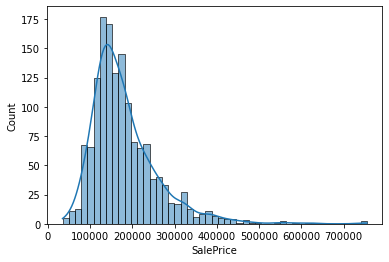

In [7]:
# Histogram
sns.histplot(data=df_train,x="SalePrice", kde=True)
print(df_train.SalePrice.skew()) # highly skewed (right skewed)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519417, 180921.19589041095, 0.9319665641512986))

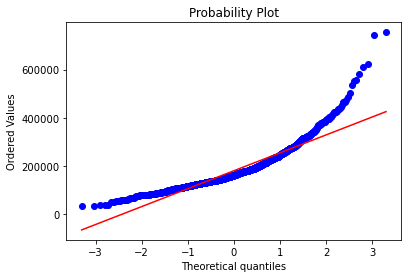

In [8]:
# QQ_plot
stats.probplot(df_train['SalePrice'],plot=plt)
# If the data is normally distributed, then it should be shown as a straight line. However, it's not a straight line here.

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='SalePrice'>

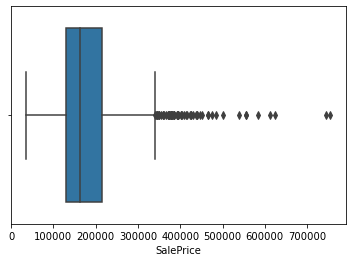

In [9]:
# box_plot
sns.boxplot(df_train['SalePrice'], orient = 'v') # with outliers

#### 3. Transform the data into normal distirbution

In [10]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

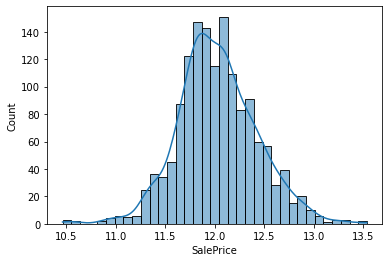

In [11]:
# Histogram
sns.histplot(data=df_train,x="SalePrice", kde=True)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826701))

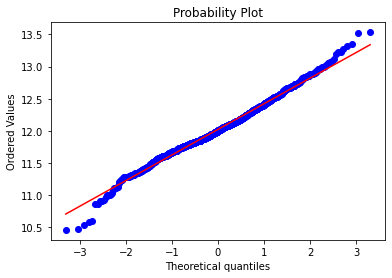

In [12]:
# QQ_plot
stats.probplot(df_train['SalePrice'],plot=plt)

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='SalePrice'>

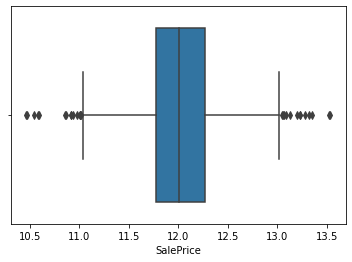

In [13]:
# box_plot
sns.boxplot(df_train['SalePrice'], orient = 'v') # we still have some outliers

#### 4. Data Preparation

In [14]:
all_data = pd.concat((df_train, df_test)).reset_index(drop = True)
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [15]:
# Since we need to use `SalePrice` later, we first drop the value here to avoid further modification.
# remove column
all_data.drop(['SalePrice'], axis = 1, inplace = True)
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### 4.1 Dealing with NaN values
In some of the features we have NA as none - they aren't missing really missing, the house just doesn't have this feature

In [16]:
all_data.isnull().sum().sort_values(ascending = False).head()

PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
FireplaceQu    1420
dtype: int64

In [17]:
NA_as_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'MSZoning']

for i in NA_as_none: 
    all_data[i] = all_data[i].fillna('None') 

all_data 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


#### 4.2 Data cleaning
Some features here are entered as number, but defined as categorical features in the system. We convert those features into `str`.

In [18]:
all_data['OverallCond'] = all_data['OverallCond'].astype(str) 
all_data['OverallQual'] = all_data['OverallQual'].astype(str) 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str) 
all_data['YearBuilt'] = all_data['YearBuilt'].astype(str) 
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str) 
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str) 
all_data['YrSold'] = all_data['YrSold'].astype(str) 
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [19]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    data_type = df.dtypes.sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    return pd.concat([total, percent, data_type], axis=1, keys=['Total','Percent','Type']) # concat by columns

In [20]:
missing_percentage(all_data)

,Total,Percent,Type
LotFrontage,486,16.65,float64
MasVnrArea,23,0.79,float64
Utilities,2,0.07,object
BsmtHalfBath,2,0.07,float64
Functional,2,0.07,object
BsmtFullBath,2,0.07,float64
Electrical,1,0.03,object
Exterior2nd,1,0.03,object
Exterior1st,1,0.03,object
GarageArea,1,0.03,float64


Based on their types, we can fill the null values.\
There are ordinal scales which will be converted to numbers( Excellent - Good - Poor is 3-2-1)


In [21]:
def Dup(x): 
    # def of "fromkeys()": https://appdividend.com/2022/07/12/python-dict-fromkeys/
    return list(dict.fromkeys(x))

In [22]:
def addS(z): 
    z = "'" + str(z) + "'" 
    return z

In [23]:
def remove_values_from_list(the_list, val): 
    return [value for value in the_list if value != val]

In [24]:
columns_2_order = ['LotShape', 'Utilities', 'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual' , 'GarageCond', 'PoolQC', 'Fence']

In [25]:
# convert ordinal categorical features into scales

for c_order in columns_2_order: 
    n = len(Dup(all_data[c_order])) 
    sample_dic = {} 
    vlist = [] 
    nlist = []
    
    for val in Dup(all_data[c_order]):
        vlist.append(val)
        nlist.append(n)
        n-=1
    
    sample_dic = dict(zip(vlist, nlist))

    all_data[c_order] = all_data[c_order].map(sample_dic) 

In [26]:
all_data['Functional'] = all_data['Functional'].fillna('Typical') 
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(0) 
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0) 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') #default values 
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0) 
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0) 
all_data['BsmtFinSF1'] = all_data['BsmtFinSF2'].fillna(0) 
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(0) 
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].fillna(0) 
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0) 
all_data['SaleType'] = all_data['SaleType'].fillna("Oth") 
all_data['GarageCars'] = all_data['GarageCars'].fillna(0) 
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0) 
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr') #default values 
all_data['GarageArea'] = all_data['GarageArea'].fillna(0) 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) #filling with mode 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0]) 
all_data['KitchenQual'] = all_data['BsmtFinSF1'].fillna(all_data['Exterior2nd'].mode()[0])

In [27]:
missing_percentage(all_data)

,Total,Percent,Type


No Missing Value any longer. Then, we can do the linear regression.

In [28]:
all_data['TotalSQFT'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] #basement + floor 1 + floor 2
all_data['Yearbuilt/remodelled'] = (all_data['YearBuilt'] + all_data['YearRemodAdd'])
all_data['BSMT'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] # combined space
all_data['TotalBathrooms'] = (all_data['FullBath'] + (all_data['HalfBath']) + all_data['BsmtFullBath'] + (all_data['BsmtHalfBath']))
# total bathrooms

In [29]:
# to avoid multicollinearity
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0) 
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) 
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) 
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) 
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [30]:
# change the dummy variables
final_features = pd.get_dummies(all_data).reset_index(drop=True) 
final_features.drop(['Id'], axis = 1, inplace = True)

final_features


,LotFrontage,LotArea,LotShape,Utilities,LandSlope,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Yearbuilt/remodelled_20052007,Yearbuilt/remodelled_20062006,Yearbuilt/remodelled_20062007,Yearbuilt/remodelled_20072007,Yearbuilt/remodelled_20072008,Yearbuilt/remodelled_20082008,Yearbuilt/remodelled_20082009,Yearbuilt/remodelled_20092009,Yearbuilt/remodelled_20092010,Yearbuilt/remodelled_20102010
0,65.0,8450,4,3,3,196.0,4,5,5,5,...,0,0,0,0,0,0,0,0,0,0
1,80.0,9600,4,3,3,0.0,3,5,5,5,...,0,0,0,0,0,0,0,0,0,0
2,68.0,11250,3,3,3,162.0,4,5,5,5,...,0,0,0,0,0,0,0,0,0,0
3,60.0,9550,3,3,3,0.0,3,5,4,4,...,0,0,0,0,0,0,0,0,0,0
4,84.0,14260,3,3,3,350.0,4,5,5,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,1936,4,3,3,0.0,3,5,4,5,...,0,0,0,0,0,0,0,0,0,0
2915,21.0,1894,4,3,3,0.0,3,5,4,5,...,0,0,0,0,0,0,0,0,0,0
2916,160.0,20000,4,3,3,0.0,3,5,4,5,...,0,0,0,0,0,0,0,0,0,0
2917,62.0,10441,4,3,3,0.0,3,5,5,5,...,0,0,0,0,0,0,0,0,0,0


The reason for me to change the variables into dummy variables is: The dummy encoded model scores better according to RMSE and R^2 values.

In [31]:
df_train.shape

(1460, 81)

### Split the dataset


In [33]:
X = final_features[:1460]
X_test = final_features[1460:]

y = pd.DataFrame(data =df_train["SalePrice"])

## Model Implementation
After obtaining the cleaned data set, we further carry out the predictive modeling. The goal is to predict houses' sales prices in US dollar based on houses' various features, i.e. the covariates such as the type of road access to the house, the kitchen quality. As previously mentioned, since the data approximately follows a normal distribution but with slight right skewed, we convert outcome sales price y using `log`. We adopted two types of modeling method, the first one is penalizing regression models including the basic linear regression, ridge and lasso where the model puts a penalty term on large coefficients. The second type of model is tree based model including the basic decision tree and ensemble random forest as well as xgboost. Since our outcome is continuous, we applied regression for all our models and adopted mean square error as our model performance evaluation where the smaller the MSE the better the model is. Due to the fact that our data is extracted from Kaggle where the actual sales price for the test set is missing, so the problem is we are not able to provide MSE on the test set. However, in order to solve for this problem, we adopted cross-validation and splitted the whole given training dataset into the subsequent train set to fit the model and the test set to evaluate the model performances and thus we're able to provide the training MSE. <br>
In the model fitting process, we tuned hyperparameters for all of our models. Specifically, for the penality models, we tuned alpha which is the penalty term, the larger the alpha is, more shrinkage was applied on coefficients and thus coefficients getting close to zero. When alpha is exactly zero, both regression models will have the same objective function as a linear regression. In tree based method, we both tuned for `max_depth` which is the maximum depth of a tree which refers to the maximum distance between the node to the leaf. If we happened to grow a very deep tree, we might running into an overfitting problem as the tree is not robust. Further, since both random forest and xg-boost are ensemble tree methods, we need to control the number of trees to build in total `n_estimator` as well. Another hyperparameter to be considered is `min_sample_leaf` which controls number of training samples can be added on each leaf and it helps further smooth the trees and avoiding overfitting problem. Model fitting code are displayed as below with each model's performance and further results discussion can be found in the next section. 

### PCA

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

In [37]:
from sklearn.decomposition import PCA

In [38]:
sc = StandardScaler() # essential part for PCA
X = sc.fit_transform(X)

In [43]:
# View the degree of price variates based on the factors that we've chosen (to get some senses)
pca = PCA(n_components=1213) #978 
X = pca.fit_transform(X)
# X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_


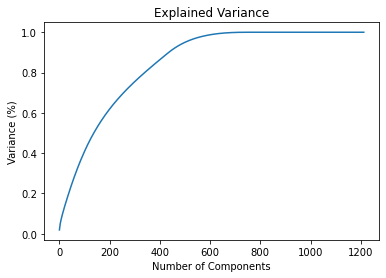

In [44]:
plt.figure() 
plt.plot(np.cumsum(explained_variance)) 
plt.xlabel('Number of Components') 
plt.ylabel('Variance (%)') 
plt.title('Explained Variance') 
plt.show()

From the plot above, we know if we want to do the data analysis, we don't need 1200 componenets. Around 250 components can help us to explain around 80% of the variance.

In [47]:
# to find the top 250 significant variables
pca_com = 250 
Var_matrix =(pd.concat([pd.DataFrame(list(final_features.columns), columns=["Factors"] ),
                        pd.DataFrame(list(explained_variance**2), columns=["^2 Variance"] )],
                        axis=1).sort_values(by='^2 Variance', ascending = False)[0:pca_com])
Var_matrix.head()

,Factors,^2 Variance
0,LotFrontage,0.000361
1,LotArea,0.000125
2,LotShape,0.000085
3,Utilities,0.000069
4,LandSlope,0.000048


In [50]:
# update the X dataset
X_new = final_features[list(Var_matrix['Factors'])]

X_new.shape
X_train = X_new[:1460] 
X_test = X_new[1460:] 

In [55]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
# X_train_train.shape, y_train_train.shape # to check their dimensions are same

((1168, 250), (1168, 1))

### Linear Regression

In [57]:
# Simple linear regression
lr = linear_model.LinearRegression().fit(X_train_train, y_train_train)
pred_train_test_lr = lr.predict(X_train_test)

# RMSE on X_train_test
lr_train_test_rmse = mean_squared_error(y_train_test, pred_train_test_lr, squared = False)
print("RMSE on train test set: %.2f" % lr_train_test_rmse)

# R2 on X_train_test
lr_train_test_r2 = r2_score(y_train_test, pred_train_test_lr)
print("R-squared on train test set: %.2f" % lr_train_test_r2)

# print()
# # The coefficients
# print("Coefficients: \n", lr.coef_)

print()

RMSE on train test set: 515.00
R-squared on train test set: -1421287.18



### Ridge Regression

Since in our dataset, there could still have the mullticollinearity. It is a good way for us to use Ridge Regression, instead of the Linear Regression. Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. When multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value.

In [58]:
# ridge regression with .parameter tuning
ridge_reg = linear_model.Ridge()
params_Ridge = {'alpha': [10, 5, 1, 0.1, 0.01, 0.001]}

Ridge_GS = GridSearchCV(ridge_reg, param_grid = params_Ridge).fit(X_train_train,y_train_train)

print("Ridge best parameter: \n", Ridge_GS.best_params_)
pred_train_test_rr = Ridge_GS.predict(X_train_test)

# RMSE on X_train_test
rr_train_test_rmse = mean_squared_error(y_train_test, pred_train_test_rr, squared = False)
print("RMSE on train test set: %.2f" % rr_train_test_rmse)

# R2 on X_train_test
rr_train_test_r2 = r2_score(y_train_test, pred_train_test_rr)
print("R-squared on train test set: %.2f" % rr_train_test_r2)
print()

Ridge best parameter: 
 {'alpha': 5}
RMSE on train test set: 0.14
R-squared on train test set: 0.89



### Lasso Regression

In [59]:
# lasso regression with parameter tuning
lasso_reg = linear_model.Lasso()
lasso_params = {'alpha':[0.00001, 0.0001, 0.001, 0.005, 0.01, 0.02, 0.03]}

Lasso_GS = GridSearchCV(lasso_reg, param_grid = lasso_params).fit(X_train_train,y_train_train)

print("Lasso best parameter: \n", Lasso_GS.best_params_)

pred_train_test_lasso = Lasso_GS.predict(X_train_test)

# RMSE on X_train_test
lasso_train_test_rmse = mean_squared_error(y_train_test, pred_train_test_lasso, squared = False)
print("RMSE on train test set: %.2f" % lasso_train_test_rmse)

# R2 on X_train_test
lasso_train_test_r2 = r2_score(y_train_test, pred_train_test_lasso)
print("R-squared on train test set: %.2f" % lasso_train_test_r2)

print()

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.043e+00, tolerance: 1.428e-02
  model = cd_fast.enet_coordinate_descent(
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.511e+00, tolerance: 1.436e-02
  model = cd_fast.enet_coordinate_descent(
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+00, tolerance: 1.428e-02
  model = cd_fast.enet_coordinate_descent(
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.678e+00, tolerance: 1.436e-02
  model = cd_fast.enet_coordinate_descent(
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Lasso best parameter: 
 {'alpha': 0.001}
RMSE on train test set: 0.16
R-squared on train test set: 0.87



/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.143e+00, tolerance: 1.781e-02
  model = cd_fast.enet_coordinate_descent(


### Tree Based Regression Models - Decision Tree

In [60]:
# decision tree
tree_gs = GridSearchCV(
  DecisionTreeRegressor(),
  param_grid = {
    "max_depth": [5, 10, 15, 20]
  },
  cv = KFold(10, shuffle=True, random_state=1234),
  scoring = "neg_root_mean_squared_error",
  n_jobs = 4
).fit(
  X_train_train,y_train_train
)

# decision tree tuning results
print("Best Estimator from Decision Tree is:",tree_gs.best_estimator_)
print("Best MSE is:",-tree_gs.best_score_)

pred_train_test_tree = tree_gs.predict(X_train_test)

# RMSE on X_train_test
tree_train_test_rmse = mean_squared_error(y_train_test, pred_train_test_tree, squared = False)
print("RMSE on train test set: %.2f" % tree_train_test_rmse)

# R2 on X_train_test
tree_train_test_r2 = r2_score(y_train_test, pred_train_test_tree)
print("R-squared on train test set: %.2f" % tree_train_test_r2)

print()

Best Estimator from Decision Tree is: DecisionTreeRegressor(max_depth=5)
Best MSE is: 0.19678031096733878
RMSE on train test set: 0.22
R-squared on train test set: 0.74



### Random Forest

In [61]:
# RF

rf = GridSearchCV(
    RandomForestRegressor(), 
    param_grid = {
        "max_depth": [100, 130, 150, 180, 200], 
        "n_estimators": [30, 40, 50, 60, 70, 80], 
        "min_samples_leaf": [4, 6, 8]}, 
    cv = KFold(5, shuffle=True, random_state=1234),
    scoring = "neg_root_mean_squared_error", 
    n_jobs= -1
).fit(
    X_train_train,y_train_train
)


# best estimator 
print("Best Estimator from Random Forest is:", rf.best_estimator_)

# best score
print("Best MSE is:", -rf.best_score_)

# predict on train test set 
pred_train_test_rf = rf.predict(X_train_test)

# RMSE on X_train_test
rf_train_test_rmse = mean_squared_error(y_train_test, pred_train_test_rf, squared = False)
print("RMSE on train test set: %.2f" % tree_train_test_rmse)

# R2 on X_train_test
rf_train_test_r2 = r2_score(y_train_test, pred_train_test_rf)
print("R-squared on train test set: %.2f" % rf_train_test_r2)
print()

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_va

/Users/stellayz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Estimator from Random Forest is: RandomForestRegressor(max_depth=130, min_samples_leaf=4, n_estimators=40)
Best MSE is: 0.15766029585676306
RMSE on train test set: 0.22
R-squared on train test set: 0.84



### XG-Boost

In [62]:
# XG-Boost

xgboost_imputer = SimpleImputer()
X_train_train = xgboost_imputer.fit_transform(X_train_train)
X_train_test = xgboost_imputer.transform(X_train_test)

params = { 'max_depth': [3, 5, 6, 10],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbr = xgb.XGBRegressor(seed = 20,objective='reg:squarederror')
xgboost_gs = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1).fit(X_train_train,y_train_train)


print("Best parameters:", xgboost_gs.best_params_)
print("Lowest RMSE: ", (-xgboost_gs.best_score_)**(1/2.0))

# predict on train set and get train MSE
pred_train_test_xg = xgboost_gs.predict(X_train_test)

# RMSE on X_train_test
xg_train_test_rmse = mean_squared_error(y_train_test, pred_train_test_xg, squared = False)
print("RMSE on train test set: %.2f" % xg_train_test_rmse)

# R2 on X_train_test
xg_train_test_r2 = r2_score(y_train_test, pred_train_test_xg)
print("R-squared on train test set: %.2f" % xg_train_test_r2)
print()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8999999999999999}
Lowest RMSE:  0.13323801671861454
RMSE on train test set: 0.14
R-squared on train test set: 0.90



### Discussion & Conclusion

In [63]:
# create dataframe for displaying model results
res = {
  "Linear Regression":pd.Series([lr_train_test_rmse, lr_train_test_r2]),
  "Lasso Regression": pd.Series([lasso_train_test_rmse, lasso_train_test_r2]),
  "Ridge Regression": pd.Series([rr_train_test_rmse,rr_train_test_r2]),
  "Decision Tree": pd.Series([tree_train_test_rmse,tree_train_test_r2]),
  "Random Forest": pd.Series([rf_train_test_rmse ,rf_train_test_r2]),
  "XG-Boost": pd.Series([xg_train_test_rmse,xg_train_test_r2])
}

result = pd.DataFrame(res)
result.index = ['RMSE', 'R Squared']

In [64]:
result

,Linear Regression,Lasso Regression,Ridge Regression,Decision Tree,Random Forest,XG-Boost
RMSE,5.150029e+02,0.157712,0.144317,0.220186,0.171415,0.138869
R Squared,-1.421287e+06,0.866712,0.888391,0.740199,0.842543,0.896660


From this table, we can observe that XG-Boost has the best performance. Therefore, we use this model to predict df_test.

In [68]:
X_train = X_new[:1460].to_numpy()
y_train = y[:1460].to_numpy()
X_test = X_new[1460:].to_numpy()

In [69]:
xgboost_imputer = SimpleImputer()
X_train = xgboost_imputer.fit_transform(X_train)
X_test = xgboost_imputer.transform(X_test)

xgbr_gs = xgb.XGBRegressor(subsample = 0.799, 
                           n_estimators=1000, 
                           max_depth=10, 
                           learning_rate = 0.01, 
                           colsample_bytree = 0.799, 
                           colsample_bylevel = 0.799, 
                           seed = 20,
                            objective='reg:squarederror').fit(X_train,y_train)

y_pred = xgbr_gs.predict(X_test)
y_pred

array([11.701373, 11.963664, 12.191026, ..., 12.015688, 11.696933,
       12.338685], dtype=float32)

### Feature Importance

In [70]:
feature_importance = xgbr_gs.feature_importances_

In [81]:
df_fi = pd.DataFrame(feature_importance * 100,
                     columns = ['feature_importance %']).sort_values(by='feature_importance %',ascending=False)
df_fi

,feature_importance %
32,9.855537
45,7.384734
47,6.040642
74,3.066140
29,2.598566
52,2.361568
26,2.201563
156,2.013915
6,1.849625
69,1.822543


In [95]:
X_new.columns[[32,45,47,74,29]]

Index(['GarageCars', 'TotalSQFT', 'TotalBathrooms', 'MSZoning_RM',
       'Fireplaces'],
      dtype='object')

From the dataframe above, we can find the most significant 5 features are `32` `45` `47` `74` `29`, correspondingly, they are `GarageCars`, `TotalSQFT`, `TotalBathrooms`, `MSZoning_RM`,`Fireplaces`.